## Лабораторная 1

In [29]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import numpy as np

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [30]:
#Подготовка изображений под аугментацию

import os
from PIL import Image, ImageOps

# Функция для добавления белого фона, инвертирования и сохранения изображения
def add_white_background_invert_and_save(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Проходим по всем изображениям в input_dir
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = Image.open(img_path)
                
                # Если изображение в RGBA (есть альфа-канал)
                if image.mode == 'RGBA':
                    background = Image.new('RGB', image.size, (255, 255, 255))
                    background.paste(image, (0, 0), image)
                    image = background
                
                # Инвертируем изображение
                inverted_image = ImageOps.invert(image)

                # Сохраняем изображение в output_dir
                output_image_path = os.path.join(output_dir, file)
                inverted_image.save(output_image_path)

In [34]:
#Аугментация

import os
import random
from PIL import Image
from torchvision import transforms

# Определяем набор трансформаций для аугментации
transformations = transforms.Compose([
    transforms.RandomRotation(15),         # Повороты до 15 градусов
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Сдвиги по осям
    #transforms.RandomHorizontalFlip(),     # Горизонтальные отражения
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Изменение яркости/контраста
])

def augment(input_folder, output_folder, augment_factor):
    
    # Для каждого изображения в оригинальном наборе данных
    for filename in os.listdir(input_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Загружаем изображение
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path)
    
            # Сохраняем оригинал в папку (если нужно)
            base_name, ext = os.path.splitext(filename)
            original_save_path = os.path.join(output_folder, f"{base_name}_{ext}")
            image.save(original_save_path)
    
            # Генерируем несколько аугментированных изображений
            for i in range(augment_factor):
                augmented_image = transformations(image)  # Применяем трансформации
                augmented_save_path = os.path.join(output_folder, f"{base_name}_{i}{ext}")
                augmented_image.save(augmented_save_path)

In [32]:
#Обработка

for i in range(1,6):
    input_folder_train = 'data/geroff_dataset/train/' + str(i)
    add_white_background_invert_and_save(input_folder_train, input_folder_train)

    input_folder_test = 'data/geroff_dataset/test/' + str(i)
    add_white_background_invert_and_save(input_folder_test, input_folder_test)


In [35]:
#Аугмент

# Количество аугментированных изображений на одно оригинальное
augment_factor = 4  # Увеличиваем до 10 изображений на каждое оригинальное

for i in range(1,6):
    input_folder_train = 'data/geroff_dataset/train/' + str(i)
    augment(input_folder_train, input_folder_train,augment_factor)

    input_folder_test = 'data/geroff_dataset/test/' + str(i)
    augment(input_folder_test, input_folder_test,augment_factor)

In [36]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Работа по датасетам

transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Загрузка данных (train и test)
train_data = datasets.ImageFolder(root='data/geroff_dataset/train', transform=transform_train)
test_data = datasets.ImageFolder(root='data/geroff_dataset/test', transform=transform_test)

# Создание DataLoader для батчевой загрузки данных
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Получим количество классов (например, римские цифры от I до X)
num_classes = len(train_data.classes)
class_names = train_data.classes
print("Классы:", train_data.classes)

Классы: ['1', '2', '3', '4', '5']


Класс: 2


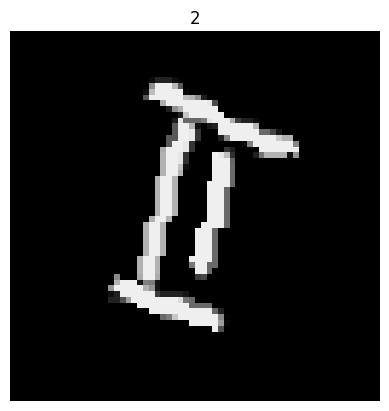

Класс: 3


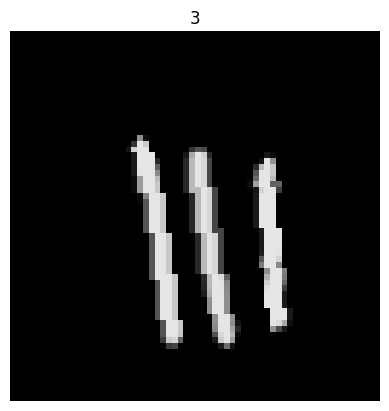

In [37]:
# Функция для отображения изображений
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0)) 
    img = np.clip(img, 0, 1) 
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Отобразим несколько случайных изображений из train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Получаем первый батч

#Показать 4 изображения из батча
for i in range(2):
    img = images[i].cpu()  # Переносим изображение на CPU для отображения
    label = labels[i].item()
    class_name = class_names[label]  # Получаем название класса

    print(f'Класс: {class_name}')  # Печатаем класс
    imshow(img, title=class_name)  # Отображаем изображение с меткой класса

In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 64 * 64 * 3  # 12288

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 512)  # Входной слой для 3 каналов (RGB)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Количество классов

    def forward(self, x):
        x = x.view(-1, 64 * 64 * 3)  # Преобразуем изображения в вектор
        x = torch.relu(self.fc1(x))  # Применяем ReLU
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Последний слой (выходной)
        return x

# Создаем модель
model = SimpleNN().to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)


TypeError: SimpleNN.__init_subclass__() takes no keyword arguments

In [66]:
import torch

def evaluate_accuracy(model, test_loader, device):
    model.eval()  # Переводим модель в режим оценки
    correct_predictions = 0
    total_images = 0
    
    with torch.no_grad():  # Выключаем градиенты, чтобы ускорить процесс
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_images += labels.size(0)
    
    accuracy = (correct_predictions / total_images) * 100  # Точность в процентах
    return accuracy

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Обучение модели
num_epochs = 7  # Количество эпох
best_accuracy = 0.0  # Начальная лучшая точность
best_model_wts = None  # Лучшие веса модели

for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим тренировки
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(-1, input_size).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(inputs)  # Прямой проход (forward)
        loss = criterion(outputs, labels)  # Вычисляем loss
        loss.backward()  # Обратный проход (backward)
        optimizer.step()  # Обновляем веса

        running_loss += loss.item()

    print(f"Эпоха [{epoch + 1}/{num_epochs}], Средняя потеря: {running_loss / len(train_loader):.4f}")

    # Оценка точности на тестовых данных после каждой эпохи
    accuracy = evaluate_accuracy(model, test_loader, device)
    print(f"Точность модели на тестовых данных: {accuracy:.2f}%")

    # Сохраняем лучшую модель, если текущая точность лучше предыдущей
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_wts = model.state_dict()  # Сохраняем веса модели

# Восстановление лучшей модели после обучения
model.load_state_dict(best_model_wts)
print(f"Лучший результат на тесте: {best_accuracy:.2f}%")


Эпоха [1/7], Средняя потеря: 0.4564
Точность модели на тестовых данных: 90.00%
Эпоха [2/7], Средняя потеря: 0.0896
Точность модели на тестовых данных: 91.67%
Эпоха [3/7], Средняя потеря: 0.0340
Точность модели на тестовых данных: 95.83%
Эпоха [4/7], Средняя потеря: 0.0257
Точность модели на тестовых данных: 95.00%
Эпоха [5/7], Средняя потеря: 0.0248
Точность модели на тестовых данных: 95.00%
Эпоха [6/7], Средняя потеря: 0.0364
Точность модели на тестовых данных: 93.33%
Эпоха [7/7], Средняя потеря: 0.0148
Точность модели на тестовых данных: 97.08%
Лучший результат на тесте: 97.08%


In [68]:
import random
import matplotlib.pyplot as plt
import torch

# Функция для отображения изображения с уменьшенным размером
def imshow(img, title=None, figsize=(5, 5)):
    img = img.numpy().transpose((1, 2, 0))  # Переводим из [C, H, W] в [H, W, C]
    img = np.clip(img, 0, 1)  # Убедимся, что пиксели в диапазоне [0, 1]
    
    plt.figure(figsize=figsize)  # Устанавливаем размер окна
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для вывода 4 случайных изображений (по одному из каждого класса) и вычисления точности
def show_random_images_from_all_classes(model, test_loader, class_names, num_images_per_class=2):
    model.eval()  # Переводим модель в режим оценки (inference)
    
    # Словарь для хранения изображений по каждому классу
    class_images = {class_name: [] for class_name in class_names}
    
    correct_predictions = 0
    total_images = 0
    
    # Перебираем все изображения из test_loader
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Собираем изображения по классу
        for i, label in enumerate(labels):
            class_name = class_names[label.item()]
            class_images[class_name].append((images[i], label))
        
        # Прогоняем изображения через модель и вычисляем точность
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Выбираем случайные изображения из каждого класса
    selected_images = []
    for class_name, images in class_images.items():
        # Выбираем случайное изображение из этого класса
        image, label = random.choice(images)
        selected_images.append((image, label, class_name))
    
    # Прогоняем изображения через модель и отображаем
    for img, label, class_name in selected_images:
        # Получаем предсказание модели
        output = model(img.unsqueeze(0).to(device))  # Добавляем размер batch
        _, predicted = torch.max(output, 1)
        predicted_class_name = class_names[predicted.item()]
        
        # Отображаем изображение с метками
        print(f'Истинная метка: {class_name}, Предсказанная метка: {predicted_class_name}')
        imshow(img.cpu(), title=f'Predicted: {predicted_class_name}, True: {class_name}', figsize=(3, 3))

# Выводим случайные изображения из каждого класса с их предсказаниями
show_random_images_from_all_classes(model, test_loader, class_names, num_images_per_class=2)



Истинная метка: 1, Предсказанная метка: 1


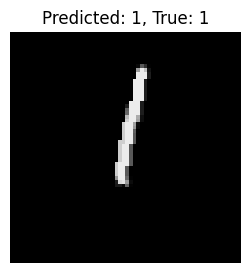

Истинная метка: 2, Предсказанная метка: 2


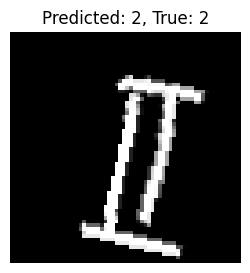

Истинная метка: 3, Предсказанная метка: 3


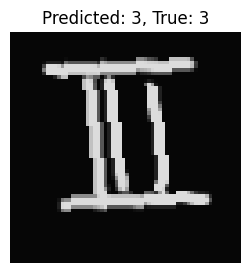

Истинная метка: 4, Предсказанная метка: 4


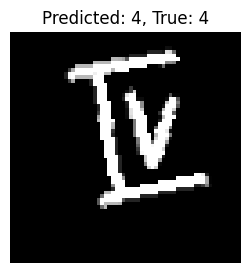

Истинная метка: 5, Предсказанная метка: 5


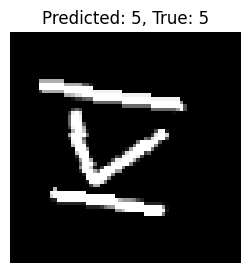

In [69]:

# Выводим случайные изображения из каждого класса с их предсказаниями
show_random_images_from_all_classes(model, test_loader, class_names, num_images_per_class=2)